# Alpha Experiment

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import json
import torchtext
import torch.nn as nn
import nltk
import pandas as pd

nltk.download('punkt')
cmap = plt.get_cmap('viridis')
from mpl_toolkits.mplot3d import Axes3D

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alicecoucke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
results_dir = '/Users/alicecoucke/Snips/automatic-data-generation/results_alpha2'
save_dir = '/Users/alicecoucke/Snips/automatic-data-generation/results_alpha2/fig'

In [3]:
from pathlib import Path
import shutil
results_dir = '/Users/alicecoucke/Snips/automatic-data-generation/results_alpha2'
runs = []

for filename in os.listdir(results_dir):
    filepath = Path(results_dir)/Path(filename)
    if filename.endswith('.pkl'):
        runs.append(torch.load(filepath, map_location='cpu'))
        
runs = [run for run in runs if (run['args']['infersent_selection']=='unsupervised')]
runs = [run for run in runs if (run['args']['cosine_threshold']==0.9)]
#runs = [run for run in runs if (run['args']['alpha']==0.5)]

runs.sort(key = lambda x : x['args']['seed'])
runs.sort(key = lambda x : x['args']['none_size'])
runs.sort(key = lambda x : x['args']['cosine_threshold'])
runs.sort(key = lambda x : x['args']['alpha'])
        
data = {}
for arg_name in runs[0]['args'].keys():
    data[arg_name] = [run['args'][arg_name] for run in runs]
data['pickle']   = np.array([run['args']['pickle'].split('/')[-1].rstrip('.pkl') for run in runs])
    
data['bleu_quality']   = np.array([run['delexicalised_metrics']['bleu_scores']['quality']['avg'] for run in runs])
data['bleu_diversity'] = np.array([run['delexicalised_metrics']['bleu_scores']['diversity']['avg'] for run in runs])
data['accuracy']       = np.array([run['delexicalised_metrics']['intent_accuracy']['avg'] for run in runs])
data['originality']       = np.array([run['delexicalised_metrics']['originality']['avg'] for run in runs])
data['transfer']   = np.array([run['delexicalised_metrics']['transfer']['metric']['avg'] for run in runs])

data['metric'] = data['accuracy']**10 * data['originality'] #* data['bleu_quality']

df = pd.DataFrame(data, columns=['pickle', 'n_epochs', 'seed', 'dataset_size', 'none_size', 'alpha', 'cosine_threshold',
                                 'bleu_quality', 'bleu_diversity', 'accuracy', 'originality', 'transfer', 'metric'])
#df = df.sort_values(by = 'alpha', ascending=True)
print(len(runs))
df.head(1000)

15


,pickle,n_epochs,seed,dataset_size,none_size,alpha,cosine_threshold,bleu_quality,bleu_diversity,accuracy,originality,transfer,metric
0,46400,50,1,200,200,0.1,0.9,0.693800,0.133990,0.974821,0.292186,0.077423,0.226416
1,43452,50,2,200,200,0.1,0.9,0.648930,0.163251,0.945468,0.355640,0.099704,0.202992
2,30263,50,3,200,200,0.1,0.9,0.628788,0.148912,0.929110,0.302323,0.103308,0.144925
3,30271,50,4,200,200,0.1,0.9,0.598594,0.148571,0.975578,0.393856,0.084545,0.307580
4,35787,50,5,200,200,0.1,0.9,0.642614,0.167195,0.959990,0.441301,0.106266,0.293361
5,46784,50,1,200,200,0.2,0.9,0.629179,0.120178,0.973151,0.463503,0.125947,0.353065
6,48780,50,2,200,200,0.2,0.9,0.677986,0.105290,0.974549,0.290633,0.078977,0.224585
7,02501,50,3,200,200,0.2,0.9,0.612014,0.138888,0.959711,0.315233,0.070145,0.208948
8,19150,50,4,200,200,0.2,0.9,0.643236,0.122861,0.983063,0.345897,0.113709,0.291582
9,10143,50,5,200,200,0.2,0.9,0.630962,0.122597,0.964729,0.337986,0.067227,0.236021


In [4]:
allbut = list(set(df.columns)-{'seed','pickle','bleu_quality','bleu_diversity','accuracy','originality','transfer','metric'})
df = df.groupby(allbut, as_index=False).mean()
df.head(20)

,alpha,n_epochs,dataset_size,none_size,cosine_threshold,seed,bleu_quality,bleu_diversity,accuracy,originality,transfer,metric
0,0.1,50,200,200,0.9,3,0.642545,0.152384,0.956994,0.357061,0.094249,0.235055
1,0.2,50,200,200,0.9,3,0.638675,0.121963,0.971041,0.350650,0.091201,0.262840
2,5.0,50,200,200,0.9,3,0.646661,0.132748,0.977600,0.245370,0.040774,0.193137


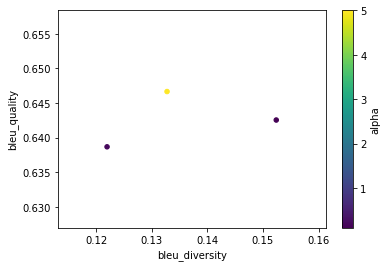

In [7]:
df.plot.scatter(x='bleu_diversity', y='bleu_quality', c='alpha', style='o', colormap='viridis', sharex=False)
plt.savefig(save_dir+'bleu_vs_bleu.png')

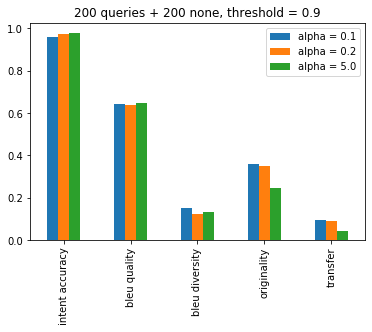

In [8]:
metric_names = ['intent accuracy', 'bleu quality', 'bleu diversity', 'originality', 'transfer']

from collections import defaultdict, OrderedDict
avg = defaultdict(list)
for run in runs:
    alpha = 'alpha = {}'.format(run['args']['alpha'])
    avg[alpha].append([run['delexicalised_metrics']['intent_accuracy']['avg'],              
                   run['delexicalised_metrics']['bleu_scores']['quality']['avg'],  
                   run['delexicalised_metrics']['bleu_scores']['diversity']['avg'],
                   run['delexicalised_metrics']['originality']['avg'],             
                   run['delexicalised_metrics']['transfer']['metric']['avg']])
for alpha, seeds in avg.items():
    avg[alpha] = np.mean(seeds, axis=0)
    
bar_df = pd.DataFrame(avg, index=metric_names)
ax = bar_df.plot.bar(rot=90)
ax.set_title('{} queries + {} none, threshold = {}'.format(runs[-1]['args']['dataset_size'], 
                                                           runs[-1]['args']['none_size'], 
                                                           runs[-1]['args']['cosine_threshold']))

plt.savefig(save_dir+'metrics.png')